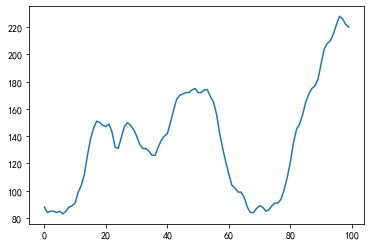

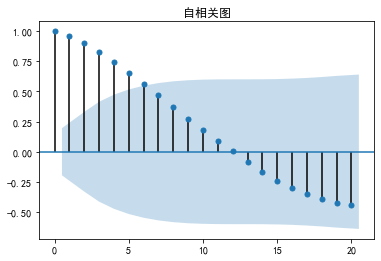

In [1]:
import pandas as pd
usage = pd.read_csv('../data/WWWusage.csv')
usage = usage['x']

# 时序图
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用于正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用于正常显示负号
usage.plot()
plt.show()

# 自相关图
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(usage)
plt.title('自相关图')
plt.show()


In [2]:
# 平稳性检测
from statsmodels.tsa.stattools import adfuller as ADF
print('原始序列的ADF检验结果为：', ADF(usage))

原始序列的ADF检验结果为： (-2.464239717203367, 0.12441935447109503, 3, 96, {'1%': -3.5003788874873405, '5%': -2.8921519665075235, '10%': -2.5830997960069446}, 444.67104090432554)


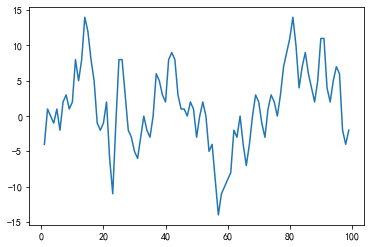

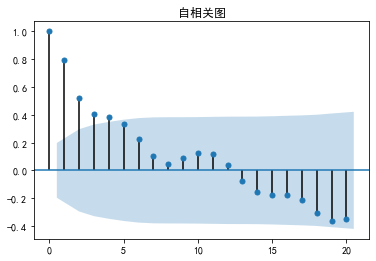

In [3]:
# 差分后的结果
D_usage = usage.diff().dropna()
D_usage.plot()
plt.show()  # 时序图
plot_acf(D_usage)
plt.title('自相关图')  # 自相关图
plt.show()

In [4]:
# 单位根检验
print('差分序列的ADF检验结果为：', ADF(D_usage)) 

差分序列的ADF检验结果为： (-2.722238490442952, 0.07026846015272711, 2, 96, {'1%': -3.5003788874873405, '5%': -2.8921519665075235, '10%': -2.5830997960069446}, 438.89606128026)


In [5]:
# 白噪声检验
from statsmodels.stats.diagnostic import acorr_ljungbox
print('差分序列的白噪声检验结果为：', acorr_ljungbox(D_usage, lags=1))  # 返回统计量和p值

差分序列的白噪声检验结果为： (array([63.9619207]), array([1.2684745e-15]))


D:\DELL\AppData\anaconda3\lib\site-packages\statsmodels\stats\diagnostic.py:524: FutureWarning: The value returned will change to a single DataFrame after 0.12 is released.  Set return_df to True to use to return a DataFrame now.  Set return_df to False to silence this warning.
  warnings.warn(msg, FutureWarning)


In [6]:
from statsmodels.tsa.arima_model import ARIMA
# 定阶
usage = usage.astype(float) 
pmax = 3
qmax = 3  
bic_matrix = []  # BIC矩阵
for p in range(pmax+1):
    tmp = []
    for q in range(qmax+1):
        try:  # 存在部分报错，所以用try来跳过报错
            tmp.append(ARIMA(usage, (p,1,q)).fit().bic)
        except:
            tmp.append(None)
    bic_matrix.append(tmp)
bic_matrix = pd.DataFrame(bic_matrix)  # 从中可以找出最小值
print(bic_matrix)

            0           1           2           3
0  632.809454  555.949091  530.359489  533.626450
1  538.640579  525.959686  530.554797  531.752779
2  533.694485  530.554804  534.302198  535.567841
3  526.640592  531.162789  535.733012  534.354168


In [7]:
# ARIMA模型预测
p,q = bic_matrix.stack().idxmin()  # 先用stack展平，然后用idxmin找出最小值位置
print('BIC最小的p值和q值为：%s、%s' %(p,q)) 
model = ARIMA(usage, (p,1,q)).fit()  # 建立ARIMA(1, 1, 1)模型
print('模型报告为：\n', model.summary2())
print('预测未来10分钟，其预测结果、标准误差、置信区间如下。\n', model.forecast(10))

BIC最小的p值和q值为：1、1
模型报告为：
                           Results: ARIMA
Model:              ARIMA            BIC:                 525.9597
Dependent Variable: D.x              Log-Likelihood:      -253.79 
Date:               2024-12-31 20:42 Scale:               1.0000  
No. Observations:   99               Method:              css-mle 
Df Model:           3                Sample:              1       
Df Residuals:       96                                    0       
Converged:          1.0000           S.D. of innovations: 3.119   
No. Iterations:     8.0000           HQIC:                519.779 
AIC:                515.5792                                      
--------------------------------------------------------------------
              Coef.    Std.Err.     t      P>|t|     [0.025   0.975]
--------------------------------------------------------------------
const         1.1205     1.2860   0.8713   0.3836   -1.4000   3.6410
ar.L1.D.x     0.6344     0.0867   7.3171   0.0000    0.